# <span style="color:teal"> Deep Reinforcement Learning for Atari Enduro-v0 </span>

### Import Required Packages

In [2]:
from __future__ import division

from time import sleep
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Permute
from keras.layers import Input, Conv2D
from keras.optimizers import Adam
from keras.activations import relu, linear
from keras.layers.advanced_activations import LeakyReLU

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor

Using TensorFlow backend.


***
### OpenAI Gym Environment

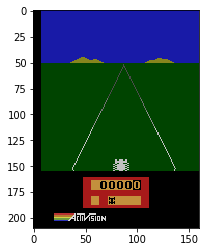

In [28]:
env = gym.make('Enduro-v0')

plt.imshow(env.render(mode='rgb_array'))
sess = tf.Session()

#### 1. *Number of possible action*

In [4]:
nb_actions = env.action_space.n
print('Total number of Possible action is :', nb_actions)

Total number of Possible action is : 9


#### 2. *Taking stack of 4 consecutive frames*

In [5]:
frame_shape = (84, 84)
window_length = 4
input_shape = (window_length,) + frame_shape
print('Input Shape is :', input_shape)

Input Shape is : (4, 84, 84)


***
### Defining class for pre-processing the game_frames

In [6]:
class GameProcess(Processor):
    def process_observation(self, observation):
        img = Image.fromarray(observation)
        img = np.array(img.resize(frame_shape).convert('L'))
        return img.astype('uint8')  

    def process_state_batch(self, batch):
        Processed_batch = batch.astype('float32') / 255.
        return Processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

***
## DeepMind Architecture

In [7]:
model = Sequential()
model.add(Permute((2, 3, 1), input_shape=input_shape))
model.add(Conv2D(32, (8, 8), strides=(4, 4)))
model.add(Activation('relu'))
model.add(Conv2D(64, (4, 4), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), strides=(1, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
activation_2 (Activation)    (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
activation_3 (Activation)    (None, 7, 7, 64)          0         
__________

***
### Configuring the Agent

#### 1. *Allocating memory for experience replay*

In [8]:
memory = SequentialMemory(limit=1000000, window_length=window_length)

#### 2.* Policy: Epsilon Greedy Exploration*
<span style="color:teal">*Gradually exploration will be decreased*</span>

In [9]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05, nb_steps=2000000)

#### 3. *Compiling DQN Agent*

In [10]:
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory, processor=GameProcess(),
               gamma=.99, train_interval=4, delta_clip=1.)

In [26]:
dqn.compile(optimizer='rmsprop', metrics=['accuracy'])

***
## <span style="color:teal"> Training the model </span>

### <span style="color:red">**-  -  Caution   -  -**</span>

In [27]:
history = dqn.fit(env, nb_steps=2000000)

Training for 2000000 steps ...
Interval 1 (0 steps performed)
  417/10000 [>.............................] - ETA: 1:12 - reward: 0.0000e+00done, took 3.242 seconds


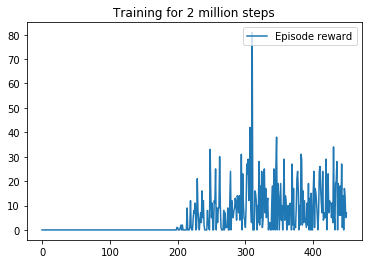

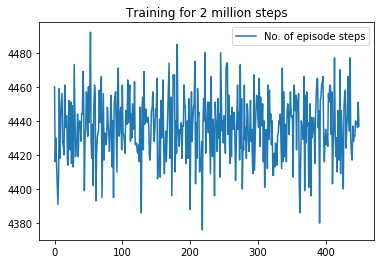

In [12]:
plt.plot(history.history['episode_reward'])
plt.title('Training for 2 million steps')
plt.legend(['Episode reward'], loc='upper right')
plt.savefig('ep_reward.png')
plt.show()

plt.plot(history.history['nb_episode_steps'])
plt.title('Training for 2 million steps')
plt.legend(['No. of episode steps'], loc='upper right')
plt.savefig('ep_steps.png')
plt.show()

In [13]:
dqn.save_weights('dqn_atari_Enduro.h5f', overwrite=True)

In [11]:
dqn.load_weights('dqn_atari_Enduro.h5f')

In [17]:
env.reset()
env = gym.wrappers.Monitor(env, "rec")
dqn.test(env, nb_episodes=2, visualize=True)
env.close()

**Trained on: AMD® Ryzen 7 1800x eight-core processor × 16, Nvidia GeForce GTX 960**
***